## Step 1: Select a Disease (ICD9 Code)

To begin our analysis, we explored the frequency of ICD9 diagnostic codes in the dataset.
Our goal was to identify a clinically relevant disease that is neither too rare nor too common,
ensuring meaningful but manageable analysis.

We used the `DIAGNOSES_ICD.csv` table to count how many **unique admissions** each ICD9 code appeared in.

We also joined with the `D_ICD_DIAGNOSES.csv` table to get the short descriptions of the codes.

In [29]:
import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

con = duckdb.connect()

# Query to get ICD9 frequencies with short titles
query = f"""
SELECT 
  d.ICD9_CODE, 
  d_desc.SHORT_TITLE, 
  COUNT(DISTINCT d.HADM_ID) AS admission_count
FROM read_csv_auto('DIAGNOSES_ICD.csv') AS d
JOIN read_csv_auto('D_ICD_DIAGNOSES.csv') AS d_desc
  ON d.ICD9_CODE = d_desc.ICD9_CODE
GROUP BY d.ICD9_CODE, d_desc.SHORT_TITLE
HAVING COUNT(DISTINCT d.HADM_ID) BETWEEN 160 AND 170
ORDER BY admission_count DESC;
"""


icd_freq_df = con.execute(query).fetchdf()
icd_freq_df.head(30)

,ICD9_CODE,SHORT_TITLE,admission_count
0,V3100,Twin-mate lb-hosp w/o cs,170
1,25053,DMI ophth uncntrld,169
2,1991,Malignant neoplasm NOS,169
3,58881,Sec hyperparathyrd-renal,169
4,9694,Pois-benzodiazepine tran,169
5,57410,Cholelith w cholecys NEC,167
6,1625,Mal neo lower lobe lung,167
7,4264,Rt bundle branch block,166
8,78609,Respiratory abnorm NEC,166
9,29420,Demen NOS w/o behv dstrb,165


## Step 2: Choosing an ICD9 code, extracting admissions and Compute LOS

We chose **Paroxysmal Supraventricular Tachycardia (ICD9 4270)** as it’s a common cardiac condition with enough cases for reliable modeling, while still being specific enough for focused analysis.

We now extract all admissions where the patient was diagnosed with ICD9 code `4270`. For each of these admissions, we compute the length of stay (LOS) as the difference between `DISCHTIME` and `ADMITTIME`, in days.

In [30]:
# Query to get hospital admissions with ICD9 code 4270
query2 = """
SELECT 
  diags.SUBJECT_ID,
  diags.HADM_ID,
  adm.ADMITTIME,
  adm.DISCHTIME,
  DATE_DIFF('day', adm.ADMITTIME, adm.DISCHTIME) AS LOS
FROM read_csv_auto('DIAGNOSES_ICD.csv') AS diags
JOIN read_csv_auto('ADMISSIONS.csv') AS adm
  ON diags.HADM_ID = adm.HADM_ID
WHERE diags.ICD9_CODE = '4270';
"""

los_df = con.execute(query2).fetchdf()
los_df.head(30)


,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,LOS
0,43738,149453,2199-06-07 15:40:00,2199-06-27 13:15:00,20
1,32367,116509,2142-12-18 19:44:00,2142-12-24 16:00:00,6
2,40000,129338,2188-01-14 19:56:00,2188-02-19 16:25:00,36
3,42458,159647,2146-07-21 14:45:00,2146-07-22 14:45:00,1
4,40013,120406,2199-06-12 06:07:00,2199-07-30 14:57:00,48
5,30247,134586,2146-11-20 19:24:00,2146-11-23 15:11:00,3
6,40695,116978,2120-11-08 18:45:00,2120-11-12 16:30:00,4
7,30810,102577,2185-10-03 17:48:00,2185-10-07 18:08:00,4
8,52087,129686,2154-12-11 13:40:00,2154-12-18 13:18:00,7
9,48640,147458,2112-03-29 23:30:00,2112-04-08 17:32:00,10


 We begin by visualizing the original distribution of Length of Stay (LOS) for patients with ICD9 code 4270. The distribution is right-skewed, as expected in clinical data. To reduce skewness, we apply a log transformation using `log1p(LOS)`, which is useful for regression modeling. The second plot shows the distribution of the log-transformed LOS, which appears more symmetric and suitable for learning algorithms.

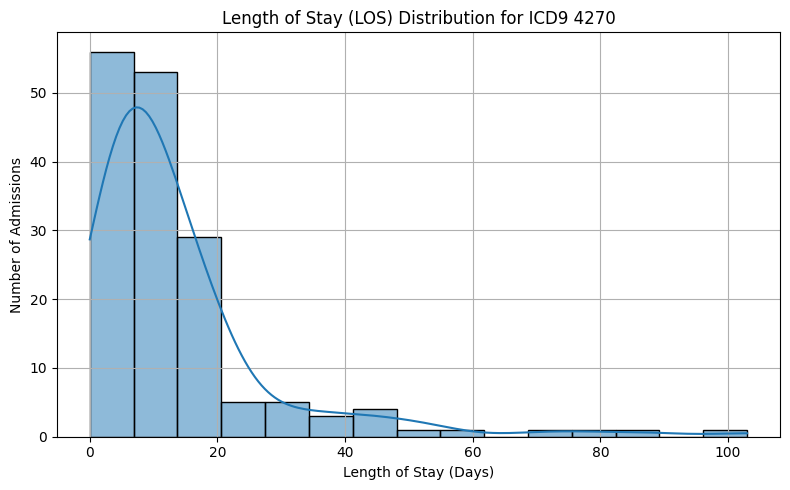

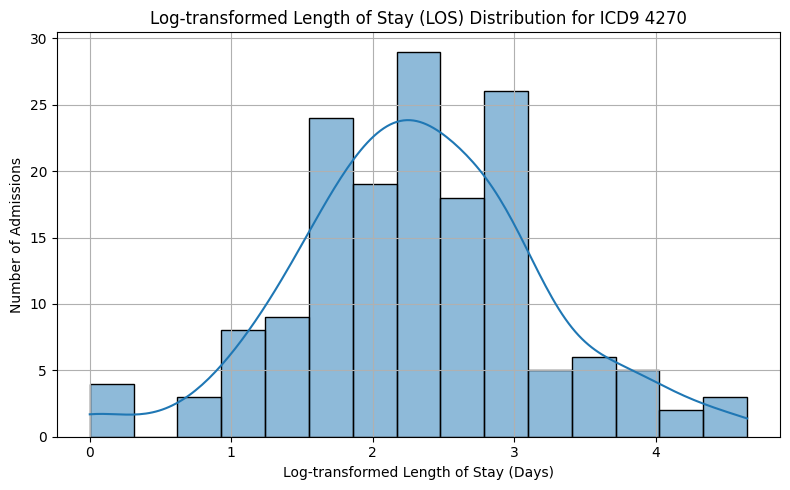

In [31]:
#Plot the LOS distribution for Tachycardia
plt.figure(figsize=(8, 5))
sns.histplot(los_df['LOS'], bins=15, kde=True)
plt.title('Length of Stay (LOS) Distribution for ICD9 4270')
plt.xlabel('Length of Stay (Days)')
plt.ylabel('Number of Admissions')
plt.grid(True)
plt.tight_layout()
plt.show()

# Apply log
los_df['LOS_log'] = np.log1p(los_df['LOS'])

# Plot the distribution of the log-transformed LOS
plt.figure(figsize=(8, 5))
sns.histplot(los_df['LOS_log'], bins=15, kde=True)
plt.title('Log-transformed Length of Stay (LOS) Distribution for ICD9 4270')
plt.xlabel('Log-transformed Length of Stay (Days)')
plt.ylabel('Number of Admissions')
plt.grid(True)
plt.tight_layout()
plt.show()

## Step 3: Data Cleaning

To prepare the dataset for analysis and modeling, we perform several filtering operations:

- Join with `PATIENTS.csv` to get `DOB` and `GENDER`
- Compute patient age at the time of admission
- Remove patients under 14 and over 89 years old
- Filter out admissions with extremely short or long Length of Stay (LOS < 1 or > 30 days)
- Encode gender numerically: Male = 1, Female = 0

These steps help us ensure the model is trained on clean, interpretable data.

In [32]:
# Load PATIENTS.csv
patients_df = con.execute("SELECT * FROM read_csv_auto('PATIENTS.csv')").fetchdf()

# Merge patient data
df = los_df.merge(patients_df[['SUBJECT_ID', 'DOB', 'GENDER']], on='SUBJECT_ID', how='left')

# Convert timestamps to datetime
df['ADMITTIME'] = pandas.to_datetime(df['ADMITTIME'])
df['DISCHTIME'] = pandas.to_datetime(df['DISCHTIME'])
df['DOB'] = pandas.to_datetime(df['DOB'])

# Compute AGE at admission
df['AGE'] = df['ADMITTIME'].dt.year - df['DOB'].dt.year
df['AGE'] = df['AGE'].apply(lambda x: 90 if x > 89 else x)

# Encode gender: M = 1, F = 0
df['GENDER'] = df['GENDER'].map({'M': 1, 'F': 0})

# Filter: Age and LOS limits
df = df[(df['AGE'] >= 14) & (df['AGE'] <= 89)]
df = df[(df['LOS'] >= 1) & (df['LOS'] <= 30)]

df = df[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'LOS', 'AGE', 'GENDER']]
df.reset_index(drop=True, inplace=True)
df.head(30)

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,LOS,AGE,GENDER
0,43738,149453,2199-06-07 15:40:00,2199-06-27 13:15:00,20,73,0
1,32367,116509,2142-12-18 19:44:00,2142-12-24 16:00:00,6,64,1
2,30247,134586,2146-11-20 19:24:00,2146-11-23 15:11:00,3,80,0
3,40695,116978,2120-11-08 18:45:00,2120-11-12 16:30:00,4,84,0
4,30810,102577,2185-10-03 17:48:00,2185-10-07 18:08:00,4,74,1
5,52087,129686,2154-12-11 13:40:00,2154-12-18 13:18:00,7,76,1
6,48640,147458,2112-03-29 23:30:00,2112-04-08 17:32:00,10,47,1
7,51459,186203,2107-11-28 19:33:00,2107-12-15 13:35:00,17,86,0
8,45783,135101,2136-02-07 12:02:00,2136-02-23 13:45:00,16,69,1
9,45092,198934,2156-09-04 19:32:00,2156-09-21 12:30:00,17,66,1


This plot shows the age distribution of patients diagnosed with ICD9 code 4270. It helps us understand the demographic spread and confirms that most cases occur in older adults.

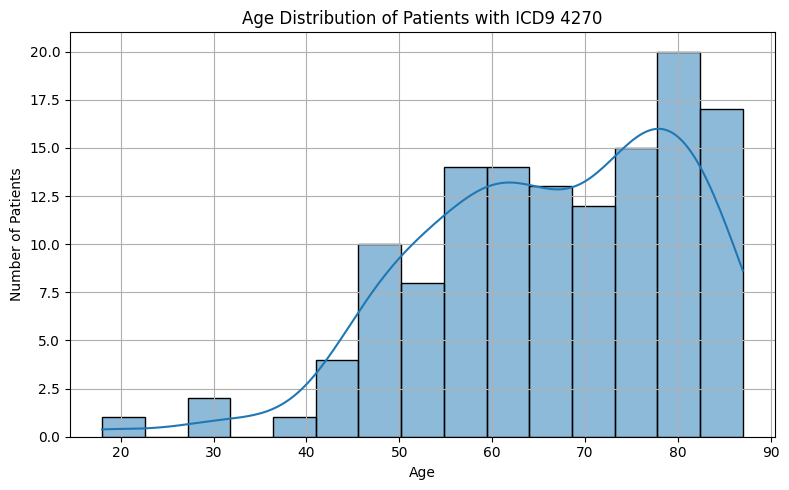

In [33]:
#Plot the age distribution of patients with tachycardia
plt.figure(figsize=(8, 5))
sns.histplot(df['AGE'], bins=15, kde=True)
plt.title('Age Distribution of Patients with ICD9 4270')
plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.tight_layout()
plt.show()

This query identifies the top 30 most frequently recorded medical items for patients with ICD9 code 4270 in the ICU. It counts how many unique ICU stays each `ITEMID` appears in, as well as the total number of occurrences across all records. This helps prioritize which clinical interventions or measurements are most common for these patients.

In [34]:
#Query the items with the highest occurance in icu stays, and the highest number of occurences
query = """
SELECT 
    ITEMID,
    COUNT(DISTINCT ICUSTAY_ID) AS icu_stay_count,
    COUNT(*) AS total_occurrences
FROM read_csv_auto('tachycardia.csv')
GROUP BY ITEMID
ORDER BY icu_stay_count DESC, total_occurrences DESC
LIMIT 30
"""

item_usage = con.execute(query).fetchdf()
print(item_usage.head())

   ITEMID  icu_stay_count  total_occurrences
0  227442             198               1772
1  220645             198               1746
2  220602             198               1717
3  220545             198               1710
4  220621             198               1653


We define a dictionary of clinically relevant `ITEMIDs`, based on the previous query for the most ocurrances, related to vital signs and respiratory support for patients with tachycardia. These include heart rate, blood pressure, oxygen saturation, and respiratory parameters.

Next, we query the `tachycardia.csv` and `ICUSTAYS.csv` tables to compute summary statistics (mean, min, max, count) for each selected item within the **first 24 hours** of ICU admission. 

We focus on the **first 24 hours** of ICU data to simulate a realistic clinical scenario: early prediction of patient outcomes. Using only the initial 24 hours allows us to train a model that can assist clinicians in making decisions shortly after ICU admission, when interventions are most impactful. This window balances the trade-off between **early decision-making** and **data availability** — going beyond 24 hours could improve accuracy but delays prediction, which is less useful in practice.

Finally, we map `ITEMID`s to readable labels and rearrange the DataFrame for clarity.

In [35]:
# Create a dictionary with the most relevant items for tachycardia
item_ids = {
    220045: "Heart Rate",
    211: "Heart Rate",
    220179: "Non Invasive Blood Pressure systolic",
    220180: "Non Invasive Blood Pressure diastolic",
    220181: "Non Invasive Blood Pressure mean",
    220210: "Respiratory Rate",
    618: "Respiratory Rate",
    223761: "Temperature Fahrenheit",
    676: "Temperature Fahrenheit",
    220277: "O2 Saturation Pulseoxymetry",
    646: "O2 Saturation Pulseoxymetry",
    220051: "Arterial Blood Pressure diastolic",
    220050: "Arterial Blood Pressure systolic",
    220052: "Arterial Blood Pressure mean",
    220228: "Glascow coma scale verbal response",
    223900: "Glascow coma scale verbal response",
    224690: "Tidal Volume (observed)",
    224687: "Minute Volume",
    224695: "Peak Insp. Pressure",
    224697: "Mean Airway Pressure",
    223835: "Inspired O2 Fraction"
}




# SQL query with time filtering (≤ 24 hours after ICU admission)
query = f"""
SELECT 
  ce.SUBJECT_ID,
  ce.HADM_ID,
  ce.ICUSTAY_ID,
  ce.ITEMID,
  AVG(ce.VALUENUM) AS mean_val,
  MIN(ce.VALUENUM) AS min_val,
  MAX(ce.VALUENUM) AS max_val,
  COUNT(ce.VALUENUM) AS count
FROM read_csv_auto('tachycardia.csv') AS ce
JOIN read_csv_auto('ICUSTAYS.csv') AS icu
  ON ce.ICUSTAY_ID = icu.ICUSTAY_ID
WHERE ce.ITEMID IN ({','.join(map(str, item_ids.keys()))})
  AND DATE_DIFF('minute', icu.INTIME, ce.CHARTTIME) BETWEEN 0 AND 1440
GROUP BY ce.SUBJECT_ID, ce.HADM_ID, ce.ICUSTAY_ID, ce.ITEMID
ORDER BY ce.SUBJECT_ID, ce.HADM_ID, ce.ICUSTAY_ID, ce.ITEMID;
"""

# Execute and load result
icu = con.execute(query).fetchdf()

# Map ITEMIDs to names
icu["ITEM_NAME"] = icu["ITEMID"].map(item_ids)

# Rearrange columns
icu = icu[["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "ITEM_NAME", "mean_val", "min_val", "max_val", "count"]]
icu.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEM_NAME,mean_val,min_val,max_val,count
0,654,136326,208646,Heart Rate,118.181818,89.0,135.0,22
1,654,136326,208646,Respiratory Rate,14.318182,0.0,27.0,22
2,654,136326,208646,O2 Saturation Pulseoxymetry,96.958333,95.0,100.0,24
3,722,116649,276248,Heart Rate,85.863636,72.0,101.0,22
4,722,116649,276248,Respiratory Rate,22.545455,18.0,29.0,22


This block retrieves the full time-series data of selected vital signs and respiratory measurements for the first 24 hours of each ICU stay. It then computes the **slope of change over time** for each item using linear regression, which helps capture the **trend** (increasing, decreasing, or stable) of each physiological signal.

The slope is calculated as the rate of change in `VALUENUM` over minutes since the first measurement. This provides insight into how the patient's condition evolves in the early stage of ICU admission, adding to the feature set dynamic, temporal information compared to the static stats like min, max and mean.

In [36]:
from scipy.stats import linregress

# Get raw time-series data (≤ 24h from ICU admission)
query_ts = f"""
SELECT 
  ce.SUBJECT_ID,
  ce.HADM_ID,
  ce.ICUSTAY_ID,
  ce.ITEMID,
  ce.CHARTTIME,
  ce.VALUENUM
FROM read_csv_auto('tachycardia.csv') AS ce
JOIN read_csv_auto('ICUSTAYS.csv') AS icu
  ON ce.ICUSTAY_ID = icu.ICUSTAY_ID
WHERE ce.ITEMID IN ({','.join(map(str, item_ids.keys()))})
  AND DATE_DIFF('minute', icu.INTIME, ce.CHARTTIME) BETWEEN 0 AND 1440
ORDER BY ce.SUBJECT_ID, ce.HADM_ID, ce.ICUSTAY_ID, ce.ITEMID, ce.CHARTTIME
"""
ts = con.execute(query_ts).fetchdf()
ts["ITEM_NAME"] = ts["ITEMID"].map(item_ids)
ts["CHARTTIME"] = pd.to_datetime(ts["CHARTTIME"])

# Compute a slope factor for each item recorded, to record the trend of the data
def compute_slope(group):
    if len(group) < 2:
        return pd.Series({"slope": None})
    
    x = (group["CHARTTIME"] - group["CHARTTIME"].min()).dt.total_seconds() / 60
    y = group["VALUENUM"]
    
    if x.nunique() == 1:
        return pd.Series({"slope": None})
    
    slope, _, _, _, _ = linregress(x, y)
    return pd.Series({"slope": slope})

trends = ts.groupby(["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "ITEM_NAME"]).apply(compute_slope).reset_index()


icu_trend = icu.merge(trends, on=["SUBJECT_ID","HADM_ID", "ICUSTAY_ID", "ITEM_NAME"], how="inner")
icu_trend.head()

C:\Users\Razvi\AppData\Local\Temp\ipykernel_1496\2702215159.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trends = ts.groupby(["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "ITEM_NAME"]).apply(compute_slope).reset_index()


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEM_NAME,mean_val,min_val,max_val,count,slope
0,654,136326,208646,Heart Rate,118.181818,89.0,135.0,22,-0.020544
1,654,136326,208646,Respiratory Rate,14.318182,0.0,27.0,22,-0.004989
2,654,136326,208646,O2 Saturation Pulseoxymetry,96.958333,95.0,100.0,24,-0.002230
3,722,116649,276248,Heart Rate,85.863636,72.0,101.0,22,0.009490
4,722,116649,276248,Respiratory Rate,22.545455,18.0,29.0,22,0.003709


We transform the ICU trend data into a **wide-format table** suitable for training a model by pivoting each metric (`mean`, `min`, `max`, `count`, `slope`) separately. Each row corresponds to a unique ICU stay, and each column represents a specific metric for a specific medical item (e.g., `Heart Rate_mean_val`, `O2 Saturation_slope`, `etc`).

After pivoting, we merge all the metric tables side-by-side into one final feature matrix. Missing values are filled with zero to ensure compatibility with modeling algorithms. This structured format captures both the **static and dynamic behavior** of each clinical measurement.

In [37]:
from functools import reduce

# Pivot each metric separately
metrics = ["mean_val", "min_val", "max_val", "count", "slope"]
pivoted_dfs = []

for metric in metrics:
    temp = icu_trend.pivot_table(
        index=["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID"],
        columns="ITEM_NAME",
        values=metric,
        aggfunc="mean"
    )
    temp.columns = [f"{item}_{metric}" for item in temp.columns]
    pivoted_dfs.append(temp)

# Combine all metric pivots side-by-side
pivoted = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), pivoted_dfs)
pivoted.reset_index(inplace=True)

# Fill all absent values with zero
pivoted = pivoted.fillna(0)

pivoted.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,Arterial Blood Pressure diastolic_mean_val,Arterial Blood Pressure mean_mean_val,Arterial Blood Pressure systolic_mean_val,Glascow coma scale verbal response_mean_val,Heart Rate_mean_val,Inspired O2 Fraction_mean_val,Mean Airway Pressure_mean_val,...,Mean Airway Pressure_slope,Minute Volume_slope,Non Invasive Blood Pressure diastolic_slope,Non Invasive Blood Pressure mean_slope,Non Invasive Blood Pressure systolic_slope,O2 Saturation Pulseoxymetry_slope,Peak Insp. Pressure_slope,Respiratory Rate_slope,Temperature Fahrenheit_slope,Tidal Volume (observed)_slope
0,654,136326,208646,0.0,0.0,0.0,0.0,118.181818,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,-0.002230,0.0,-0.004989,0.000000,0.0
1,722,116649,276248,0.0,0.0,0.0,0.0,85.863636,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.001118,0.0,0.003709,0.000000,0.0
2,747,130986,230340,0.0,0.0,0.0,0.0,63.636364,50.0,6.0,...,0.0,0.0,-0.006778,-0.009979,-0.036872,-0.069529,0.0,0.003278,0.001863,0.0
3,747,179560,207452,0.0,0.0,0.0,0.0,76.436364,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,-0.003668,0.0,0.011799,0.000332,0.0
4,2093,129899,202913,0.0,0.0,0.0,12.3,102.909091,0.0,0.0,...,0.0,0.0,-0.004677,-0.008355,-0.029108,0.009850,0.0,-0.002411,-0.001419,0.0


We load ICU stay details from `ICUSTAYS.csv` and join them with the pivoted vitals data using `SUBJECT_ID`, `HADM_ID`, and `ICUSTAY_ID`. This adds ICU admission (`INTIME`), discharge (`OUTTIME`), and recorded Length of Stay (`LOS`) to our dataset.

To ensure consistent and meaningful targets for modeling, we filter out outlier LOS values, keeping only those between **1 and 30 days**. This table forms the basis for training and evaluating our model.

In [38]:
# Load ICUSTAYS.csv
icustays_df = con.execute("""
    SELECT ICUSTAY_ID, SUBJECT_ID, HADM_ID, INTIME, OUTTIME, LOS
    FROM read_csv_auto('ICUSTAYS.csv')
""").fetchdf()

# Join vitals data with icustays on ICUSTAY_ID
pivoted_with_icu = pivoted.merge(icustays_df, on=["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID"], how="left")

# Filter out LOS outside of [1, 30] days
if 'LOS' in pivoted_with_icu.columns:
    pivoted_with_icu = pivoted_with_icu[(pivoted_with_icu["LOS"] >= 1) & (pivoted_with_icu["LOS"] <= 30)]

pivoted_with_icu.reset_index(drop=True, inplace=True)
pivoted_with_icu.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,Arterial Blood Pressure diastolic_mean_val,Arterial Blood Pressure mean_mean_val,Arterial Blood Pressure systolic_mean_val,Glascow coma scale verbal response_mean_val,Heart Rate_mean_val,Inspired O2 Fraction_mean_val,Mean Airway Pressure_mean_val,...,Non Invasive Blood Pressure mean_slope,Non Invasive Blood Pressure systolic_slope,O2 Saturation Pulseoxymetry_slope,Peak Insp. Pressure_slope,Respiratory Rate_slope,Temperature Fahrenheit_slope,Tidal Volume (observed)_slope,INTIME,OUTTIME,LOS
0,654,136326,208646,0.0,0.0,0.0,0.0,118.181818,0.000000,0.0,...,0.000000,0.000000,-0.002230,0.0,-0.004989,0.000000,0.0,2138-08-03 00:49:00,2138-08-11 16:33:00,8.6556
1,747,179560,207452,0.0,0.0,0.0,0.0,76.436364,0.000000,0.0,...,0.000000,0.000000,-0.003668,0.0,0.011799,0.000332,0.0,2141-02-23 13:02:20,2141-02-28 10:34:11,4.8971
2,6697,124409,265310,0.0,0.0,0.0,10.3,66.521739,0.000000,0.0,...,0.002996,0.002090,0.004464,0.0,0.001066,0.001131,0.0,2167-12-25 14:55:32,2167-12-26 20:40:03,1.2392
3,6697,151196,282019,0.0,0.0,0.0,9.8,88.684211,55.000000,0.0,...,-0.008152,-0.004756,0.000540,0.0,0.004688,0.000000,0.0,2168-01-07 10:02:12,2168-01-08 21:53:19,1.4938
4,6697,168932,281994,0.0,0.0,0.0,11.2,112.750000,88.571429,0.0,...,0.011116,-0.003405,0.003587,0.0,-0.002106,0.000126,0.0,2167-08-18 09:48:33,2167-08-24 21:23:42,6.4827


To illustrate patient variability, we select three representative ICU stays based on their Length of Stay (LOS): the **shortest**, **median**, and **longest**. These examples will help visualize how clinical measurements evolve across different LOS outcomes and provide context for the model’s predictions.

In [39]:
# Choose three patients for display
los_sorted = pivoted_with_icu.sort_values("LOS")
shortest = los_sorted.iloc[0]["ICUSTAY_ID"]
median = los_sorted.iloc[len(los_sorted)//2+1]["ICUSTAY_ID"]
longest = los_sorted.iloc[-1]["ICUSTAY_ID"]
selected_ids = [shortest, median, longest]

We load raw time-series chart event data and merge it with ICU stay information to compute the **relative time (in days)** since ICU admission for each measurement. Then, we filter the dataset to include only the three selected patients (shortest, median, longest LOS) and restrict the data to the **first 24 hours** of their ICU stay.

This filtered dataset is used for visualizing patient-specific intervention timelines and identifying early trends in their clinical trajectories.

In [40]:
# Read the chart events data
ce = pd.read_csv("tachycardia.csv", parse_dates=["CHARTTIME"], low_memory=False)

# Read ICU stays
icu = pd.read_csv("ICUSTAYS.csv", parse_dates=["INTIME"])

# Merge and compute relative time from ICU admission
merged = ce.merge(icu[["ICUSTAY_ID", "INTIME"]], on="ICUSTAY_ID")
merged["rel_time_days"] = (merged["CHARTTIME"] - merged["INTIME"]).dt.total_seconds() / (3600 * 24)

# Filter only for the selected ICU stays
merged_filtered = merged[merged["ICUSTAY_ID"].isin(selected_ids)]

# Keep only rows where the event is within the first 24 hours
merged_filtered = merged_filtered[merged_filtered["rel_time_days"] <= 1]

This visualization shows the evolution of charted clinical measurements during the **first 24 hours** of ICU stay for each of the three selected patients (shortest, median, longest LOS).

Each dot represents a recorded measurement (`VALUENUM`) at a given time, colored by `ITEMID` to differentiate clinical items. A **smoothed mean trendline** with a shaded confidence ribbon (±1 standard deviation) is plotted over time bins to reveal underlying patterns and variability.

This helps visually compare early trends across patients with different lengths of stay.

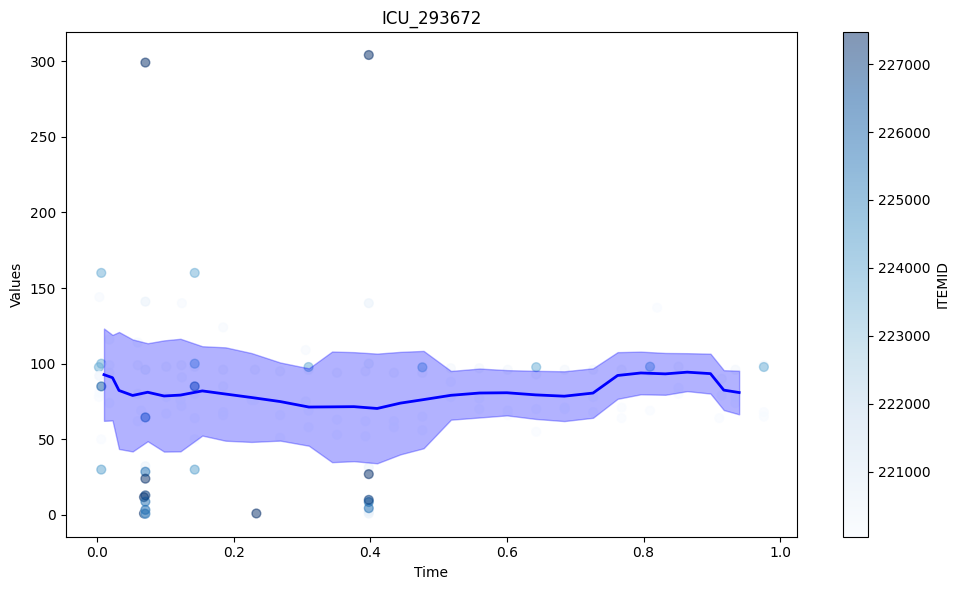

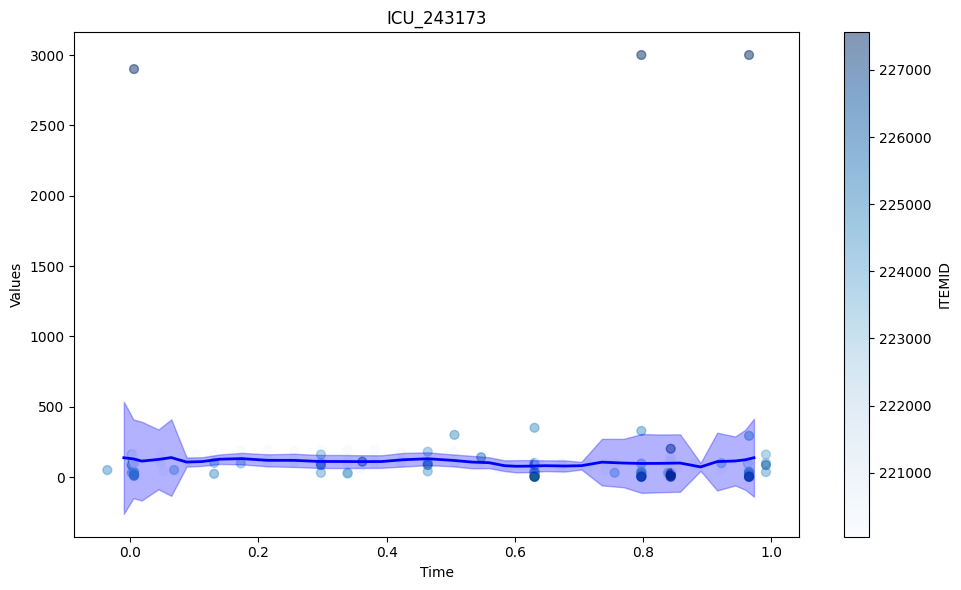

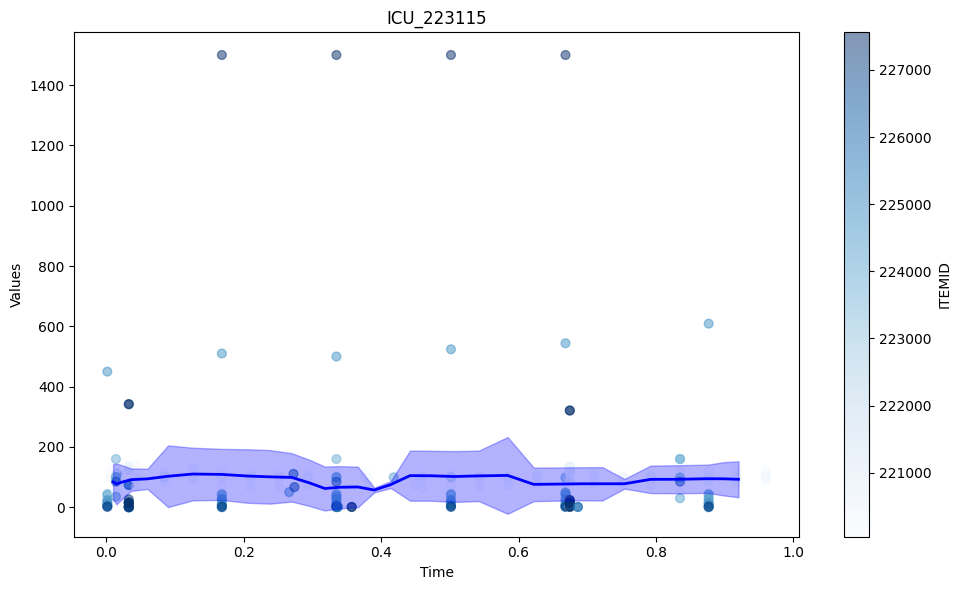

In [41]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

plot_data = merged[
    (merged["rel_time_days"] <= 1) & 
    (merged["ITEMID"])
].copy()

plot_data["ITEM_NAME"] = plot_data["ITEMID"]
plot_data["time_bin"] = (plot_data["rel_time_days"] * 100).round() / 100

for icu_id in selected_ids:
    patient_data = plot_data[plot_data["ICUSTAY_ID"] == icu_id]

    plt.figure(figsize=(10, 6))

    # Normalize ITEMID for continuous color mapping
    norm = Normalize(vmin=patient_data["ITEMID"].min(), vmax=patient_data["ITEMID"].max())
    cmap = plt.cm.Blues

    # Scatterplot with color mapped to ITEMID
    sc = plt.scatter(
        patient_data["rel_time_days"],
        patient_data["VALUENUM"],
        c=patient_data["ITEMID"],
        cmap=cmap,
        norm=norm,
        alpha=0.5,
        s=40
    )

    # Add colorbar
    cbar = plt.colorbar(sc)
    cbar.set_label("ITEMID")

    # Group by time bins
    trend = (
        patient_data
        .groupby("time_bin")["VALUENUM"]
        .agg(["mean", "std"])
        .reset_index()
        .sort_values("time_bin")
        .rolling(window=5, center=True, min_periods=1)
        .mean()
    )

    # Plot smoothed trendline and shaded ribbon
    plt.plot(trend["time_bin"], trend["mean"], color="blue", linewidth=2, label="Smoothed Mean")
    plt.fill_between(trend["time_bin"], trend["mean"] - trend["std"], trend["mean"] + trend["std"],
                     color="blue", alpha=0.3)

    plt.title(f"ICU_{icu_id}")
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.tight_layout()
    plt.show()

This improved visualization focuses only on the selected **relevant clinical items** (e.g., heart rate, blood pressure, oxygen saturation) for the three selected ICU stays.

Each dot shows a measurement over time, now colored by the **item label** for better interpretability. The trendline represents the smoothed average of all values across time bins, with a shaded band showing variability (±1 standard deviation).

By plotting specific vital signs, this chart gives a clearer picture of how early clinical indicators evolve for patients with different lengths of stay, helping with both understanding and interpretability.

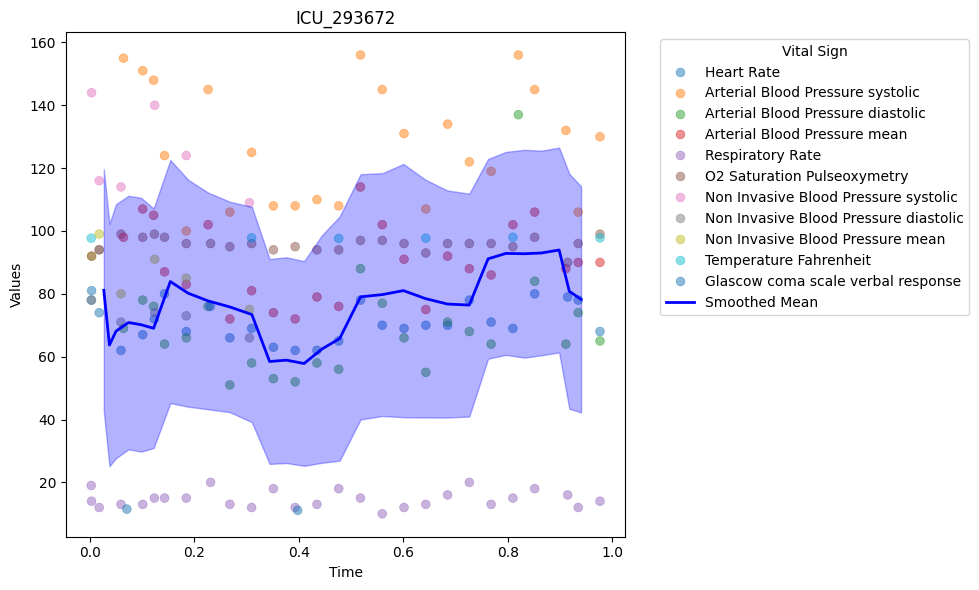

In [ ]:
plot_data = merged[
    (merged["rel_time_days"] <= 1) &
    (merged["ITEMID"].isin(item_ids.keys()))
].copy()

plot_data["ITEM_NAME"] = plot_data["ITEMID"].map(item_ids)
plot_data["time_bin"] = (plot_data["rel_time_days"] * 100).round() / 100

for icu_id in selected_ids:
    patient_data = plot_data[plot_data["ICUSTAY_ID"] == icu_id]

    plt.figure(figsize=(10, 6))

    # Scatterplot
    sns.scatterplot(
        data=patient_data,
        x="rel_time_days",
        y="VALUENUM",
        hue="ITEM_NAME",
        palette="tab10",
        alpha=0.5,
        s=40,
        edgecolor=None
    )

    # Group by time bins
    trend = (
        patient_data
        .groupby("time_bin")["VALUENUM"]
        .agg(["mean", "std"])
        .reset_index()
        .sort_values("time_bin")
        .rolling(window=5, center=True, min_periods=1)
        .mean()
    )

    # Plot smoothed trendline and shaded ribbon
    plt.plot(trend["time_bin"], trend["mean"], color="blue", linewidth=2, label="Smoothed Mean")
    plt.fill_between(trend["time_bin"], trend["mean"] - trend["std"], trend["mean"] + trend["std"],
                     color="blue", alpha=0.3)

    plt.title(f"ICU_{icu_id}")
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.legend(title="Vital Sign", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

This scatterplot explores the relationship between **mean heart rate** and **length of stay (LOS)** in the ICU. Each point represents one ICU stay. 

We chose **Heart Rate** because it is a core vital sign that reflects a patient's cardiovascular and overall physiological status. In the context of **tachycardia** (abnormally fast heart rate), it is directly relevant to the diagnosis and may provide early indicators of patient severity, helping to predict outcomes like length of stay.

The goal is to visually assess whether higher or lower heart rates in the first 24 hours are associated with shorter or longer LOS, providing intuition about possible feature relevance for modeling.

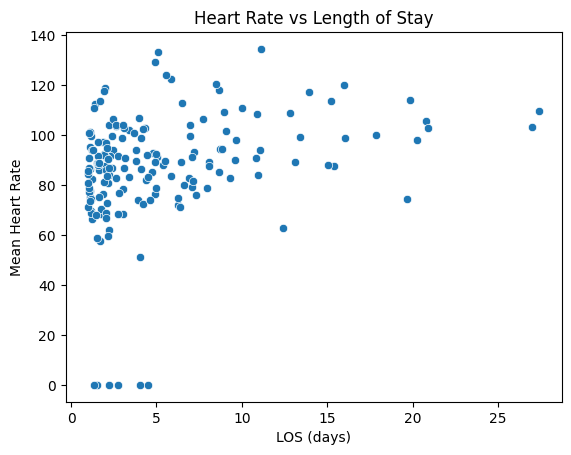

In [ ]:
# Example: How Heart Rate correlates with LOS
sns.scatterplot(data=pivoted_with_icu, x="LOS", y="Heart Rate_mean_val")
plt.title("Heart Rate vs Length of Stay")
plt.xlabel("LOS (days)")
plt.ylabel("Mean Heart Rate")
plt.show()

We train a machine learning model to predict **Length of Stay (LOS)** using early ICU data.

🔹 **Model**: We use an `XGBRegressor`, a gradient boosting model known for handling tabular data and non-linear interactions well.

🔹 **Features**: We select engineered features from vitals (e.g., mean, count, slope) along with demographics (`AGE`, `GENDER`).

🔹 **Target**: The LOS is log-transformed (`log1p`) to reduce skewness and improve model performance.

🔹 **Training & Validation**:
- We use `GridSearchCV` with 5-fold cross-validation to find the best hyperparameters.
- The best model is retrained on the training split and evaluated on a hold-out test set.

🔹 **Metrics**:
- **MAE** (Mean Absolute Error)
- **RMSE** (Root Mean Squared Error)
- **R²** (Coefficient of Determination)

This provides a robust evaluation of how well early patient data can predict ICU stay length.

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Merge pivoted vitals with demographics
merged_df = pivoted_with_icu.merge(df[["SUBJECT_ID", "HADM_ID", "AGE", "GENDER"]], on=["SUBJECT_ID","HADM_ID"], how="left")

# Feature selection
feature_cols = [col for col in pivoted_with_icu.columns if col.endswith("_val") or col.endswith("_count") or col.endswith("_slope")]
feature_cols += ["AGE", "GENDER"]

# Prepare model data
model_data = merged_df[feature_cols + ["LOS"]].dropna()
X = model_data[feature_cols]
y = model_data["LOS"]
y_log = np.log1p(y)

# Grid search setup
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 10],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}


xgb = XGBRegressor(objective="reg:squarederror", random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y_log)

# Evaluate best model on a test set
best_model = grid_search.best_estimator_

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
y_train_log = np.log1p(y_train)

best_model.fit(X_train, y_train_log)

# Predict and reverse log transform
preds_log = best_model.predict(X_test)
preds = np.expm1(preds_log)

# Evaluation
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print("Best Hyperparameters:", grid_search.best_params_)
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R-squared: {r2:.3f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
MAE: 2.899
RMSE: 3.905
R-squared: 0.313


### 🔍 Model Results Interpretation

After performing grid search and evaluating the best XGBoost model, we obtained the following results:

- **Best Hyperparameters**:
  - `max_depth`: 10 → Allows modeling complex interactions.
  - `learning_rate`: 0.2 → Faster convergence.
  - `n_estimators`: 100 → Balanced number of boosting rounds.
  - `subsample` & `colsample_bytree`: 0.8 → Adds randomness to prevent overfitting.

---

### 📊 Performance Metrics on Test Set

| Metric  | Value   | Interpretation |
|---------|---------|----------------|
| **MAE** | 2.899   | On average, the predicted LOS differs from the true LOS by about 2.9 days. |
| **RMSE**| 3.905   | Larger errors are penalized more. This suggests some outliers exist in prediction errors. |
| **R²**  | 0.313   | About 31.3% of the variance in LOS is explained by the model. While not perfect, this is a meaningful improvement over a naïve baseline and indicates moderate predictive power. |

---

### 📌 Conclusion

These results suggest that early ICU data can offer useful signals for predicting LOS, though there's still considerable variability not captured by the model. Further improvements could come from:
- Including additional temporal features or comorbidities,
- Using more complex temporal models (e.g., LSTMs),
- Incorporating clinician notes or medication data.

Still, even a modest R² can support **early decision-making** in clinical settings, especially for resource planning.

To interpret the model's predictions, we use **LIME (Local Interpretable Model-agnostic Explanations)**.

LIME builds a simple interpretable model around a **single prediction** to explain which features contributed most to that prediction. This is particularly useful in clinical settings.

Here, we generate a LIME explanation for the **first test instance**, revealing how specific features (e.g., heart rate, oxygen saturation) influenced the model’s estimated Length of Stay.

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
from IPython.display import HTML

# LIME Interpretation
X_train_np = X_train.values
X_test_np = X_test.values

explainer = LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=feature_cols,
    mode='regression'
)

i = 0
exp = explainer.explain_instance(X_test_np[i], best_model.predict)

HTML(exp.as_html())

### 🧠 LIME Interpretation: Why the Model Predicted ~1.86 Days LOS

This explanation shows how specific features influenced the model's prediction for a single ICU patient. The predicted Length of Stay (LOS) is **approximately 1.86 days**.

---

#### 📈 Features That Increased Predicted LOS
| Feature                                   | Value   | Interpretation |
|-------------------------------------------|---------|----------------|
| **O2 Saturation Pulseoxymetry (min)**     | 82.00   | Low oxygen saturation suggests possible respiratory distress. |
| **AGE**                                   | 86      | Older age typically correlates with longer recovery. |
| **Respiratory Rate slope**                | -0.00   | Flat or no improvement in breathing trend may signal lack of recovery. |

---

#### 📉 Features That Decreased Predicted LOS
| Feature                                   | Value   | Interpretation |
|-------------------------------------------|---------|----------------|
| **Heart Rate (max)**                      | 91.00   | Heart rate is within acceptable range for tachycardia, not extreme. |
| **Temperature Fahrenheit (mean)**         | 97.38   | Normal body temperature implies physiological stability. |
| **Non-Invasive BP (systolic, mean)**      | 131.46  | Indicates good cardiovascular status. |

---

### ✅ Summary
The model predicted a **short ICU stay** due to mostly stable vital signs, with only mild indicators (e.g., age and O₂ saturation) pushing LOS slightly upward. LIME confirms that the model’s reasoning aligns with clinical expectations, supporting its trustworthiness.